## Compare an ensemble of representations from deep nets using ADS and CKA

In [2]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import dsutils 
import metrics

import pandas as pd
import random
import pickle 

from sklearn.manifold import MDS
from sklearn.decomposition import PCA


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


### Get the filenames of the sample images

In [3]:
fnames = os.listdir('../imagenet-sample-images/dataset/test/')
fnames.sort()

M = len(fnames)  # number of test samples

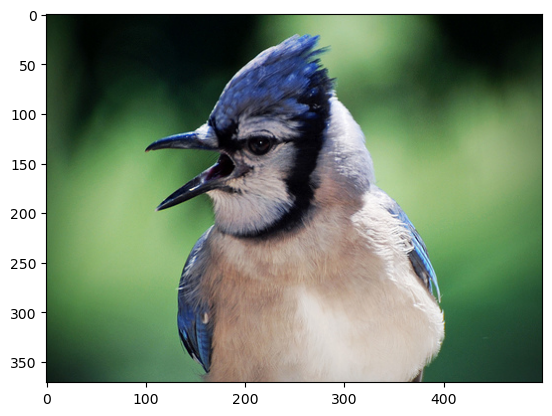

In [4]:
# Show an image

trial_image = fnames[17]
input_image = Image.open('../imagenet-sample-images/dataset/test/'+ trial_image)

plt.imshow(input_image)

### Extract internal representations of some networks
Which internal representation it is is specified in the file extract_internal_reps.py.  This is currently configured to extract the outputs of the penultimate layer in each network.

In [ ]:
# Takes a while

import extract_internal_reps

data_dir = '../imagenet-sample-images'

model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "inceptionv3", "densenet", "mobilenetv2","vgg11", "vgg11_bn", "vgg13", "vgg13_bn", "vgg16", "vgg16_bn", "vgg19", "vgg19_bn"]

internal_reps = []
for model in model_names:
    internal_reps.append(extract_internal_reps.extract_rep(model, data_dir))
    print(model + " done")

### Save and load extracted representations 

In [264]:
# Save extracted representations

reps = {}
for i, model_name in enumerate(model_names):
    reps[model_name] = internal_reps[i]

with open('internal_reps.pkl', 'wb') as f:
    pickle.dump(reps, f)

In [5]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [7]:
# Models you want to load 

# model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "vgg16"]

model_names = [x for x in avail_models if not (x.startswith('regnet') or x.startswith('wide') or x.startswith('squeeze') )]
model_names = model_names[0:-4]

# model_names = avail_models[0:15]

model_names

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'swin_b',
 'swin_s',
 'swin_t',
 'swin_v2_b',
 'swin_v2_s',
 'swin_v2_t',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'vit_b_16']

In [8]:
# Load a specified set of internal reps in a dictionary 

repDict = {}

N_models = len(model_names)
for model_name in model_names:
    with open('reps/' + model_name + '_internal_rep_classifier.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict.keys()]
internal_reps = [value[0] for value in repDict.values()]


alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
googlenet
inception_v3
maxvit_t
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
shufflenet_v2_x1_5
shufflenet_v2_x2_0
swin_b
swin_s
swin_t
swin_v2_b
swin_v2_s
swin_v2_t
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19
vgg19_bn
vit_b_16


In [9]:
# Print number of neurons in each extracted representation

model_neurons = [internal_rep.shape[1] for internal_rep in internal_reps]
print(model_neurons)

[9216, 1024, 1536, 768, 768, 1024, 2208, 1664, 1920, 1280, 1280, 1408, 1536, 1792, 2048, 2304, 2560, 1280, 1280, 1280, 1024, 2048, 512, 1280, 1280, 1280, 1280, 1280, 960, 576, 2048, 2048, 512, 512, 2048, 2048, 2048, 2048, 1024, 1024, 1024, 2048, 1024, 768, 768, 1024, 768, 768, 25088, 25088, 25088, 25088, 25088, 25088, 25088, 25088, 768]


In [10]:
[internal_rep.shape for internal_rep in internal_reps]

[torch.Size([1000, 9216]),
 torch.Size([1000, 1024, 1, 1]),
 torch.Size([1000, 1536, 1, 1]),
 torch.Size([1000, 768, 1, 1]),
 torch.Size([1000, 768, 1, 1]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 2208]),
 torch.Size([1000, 1664]),
 torch.Size([1000, 1920]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1408]),
 torch.Size([1000, 1536]),
 torch.Size([1000, 1792]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2304]),
 torch.Size([1000, 2560]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 512, 7, 7]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 960]),
 torch.Size([1000, 576]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 512]),
 torch.Size([1000, 512]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torc

In [11]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]

[torch.Size([1000, 9216]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 1536]),
 torch.Size([1000, 768]),
 torch.Size([1000, 768]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 2208]),
 torch.Size([1000, 1664]),
 torch.Size([1000, 1920]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1408]),
 torch.Size([1000, 1536]),
 torch.Size([1000, 1792]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2304]),
 torch.Size([1000, 2560]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 25088]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 960]),
 torch.Size([1000, 576]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 512]),
 torch.Size([1000, 512]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch

### Compute ADS with coarse decoding task

In [60]:
df = pd.read_csv('imagenet_categories_synset.csv')
print(df)
cats = pd.unique(df["categories"])


     index     synset                                              words  \
0        0  n01440764                                 tench, Tinca tinca   
1        1  n01443537                        goldfish, Carassius auratus   
2        2  n01484850  great white shark, white shark, man-eater, man...   
3        3  n01491361                    tiger shark, Galeocerdo cuvieri   
4        4  n01494475                       hammerhead, hammerhead shark   
..     ...        ...                                                ...   
995    995  n13044778                                          earthstar   
996    996  n13052670  hen-of-the-woods, hen of the woods, Polyporus ...   
997    997  n13054560                                             bolete   
998    998  n13133613                              ear, spike, capitulum   
999    999  n15075141       toilet tissue, toilet paper, bathroom tissue   

    categories  
0         fish  
1         fish  
2        shark  
3        shark  
4 

In [61]:
# Make coarse category decoding tasks

z = []
for k in cats[:]:
    zpd = (df["categories"] == k)
    zpd = zpd[0:M]
    zarr = 2*zpd.to_numpy() - 1
    z.append(zarr.reshape(M,1))

In [62]:
# Compute Average decoding similarity scores 

# TO DO: save precomputed kernels

ds = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1)
Cz = dsutils.bespoke_cov_matrix(z)
cached = ds.cache(internal_reps) # this part takes a long time
DSscores = ds.score(internal_reps,Cz,cached)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
55
56
Done caching.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [121]:
# Save the kernels and the scores 

ds_dict = dict(zip(model_names, cached))
with open('Kx_cache_a0b1.pkl', 'wb') as f:
    pickle.dump(ds_dict, f)

np.save('DSscores_a0b1_57models.npy', DSscores, model_names)

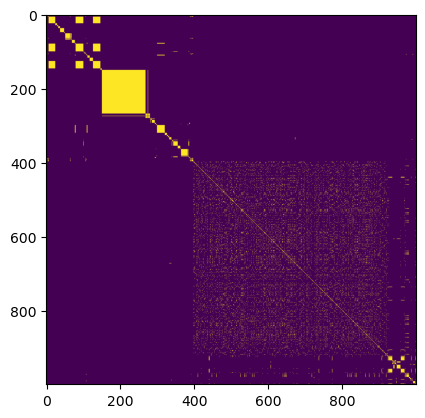

In [63]:
# Look at the covariance matrix

plt.imshow(Cz)


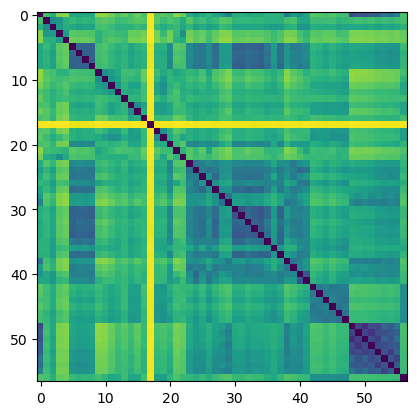

In [126]:
# Look at a particular distance metric

dists_ds = np.arccos(DSscores)
plt.imshow(dists_ds)

### Compute arccos(CKA) between each representation

In [66]:
cka = metrics.LinearCKA(center_columns=True)  # TO DO:  there is some numerical problem with the CKA funtion s.t. it sometimes returns values slightly larger than 1

CKAscores = (1/2)*np.identity(len(internal_reps))

for i in range(len(internal_reps)):
    for j in range(len(internal_reps)):
        if j < i:
            CKAscores[i,j] = cka.score(internal_reps[i].numpy(),internal_reps[j].numpy())
    print(i)
CKAscores = CKAscores + CKAscores.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


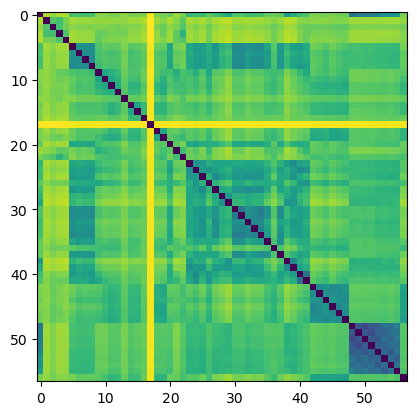

In [74]:
dists_cka = np.arccos(CKAscores)
plt.imshow(dists_cka)

In [75]:
# Compute Euclidean distance between kernels

euc_dist = np.zeros((len(internal_reps), len(internal_reps)))

for i in range(len(internal_reps)):
    for j in range(len(internal_reps)):
        if j < i:
            euc_dist[i,j] = metrics.kernel_euc_dist(internal_reps[i].numpy(),internal_reps[j].numpy())

    print(i)

euc_dist = euc_dist + euc_dist.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


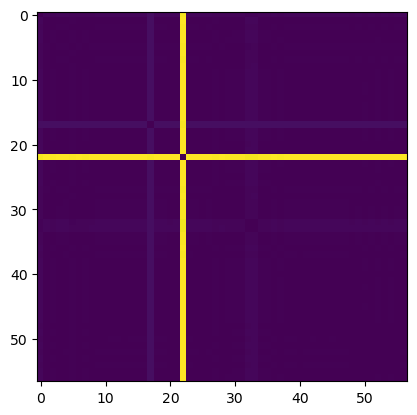

In [76]:
plt.imshow(euc_dist)

In [103]:
# Compute Bures distance

bures_dist = np.zeros((len(internal_reps), len(internal_reps)))

for i in range(len(internal_reps)):
    for j in range(len(internal_reps)):
        if j < i:
            bures_dist[i,j] = metrics.sq_bures_metric(internal_reps[i].numpy(),internal_reps[j].numpy())

    print(i)

bures_dist = bures_dist + bures_dist.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


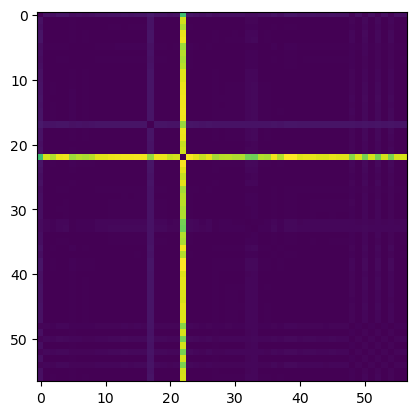

In [104]:
plt.imshow(bures_dist)

### MDS - PCA plots for visualization

In [144]:
# ADS

embedding = MDS(n_components=60, metric= True, eps = 0.00001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(np.abs(np.real(dists_ds)))
embedding.stress_

np.float64(0.04755157281559735)

In [145]:
pca = PCA(n_components=3)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.4240615430487925)

Text(0.5, 0.92, 'ADS')

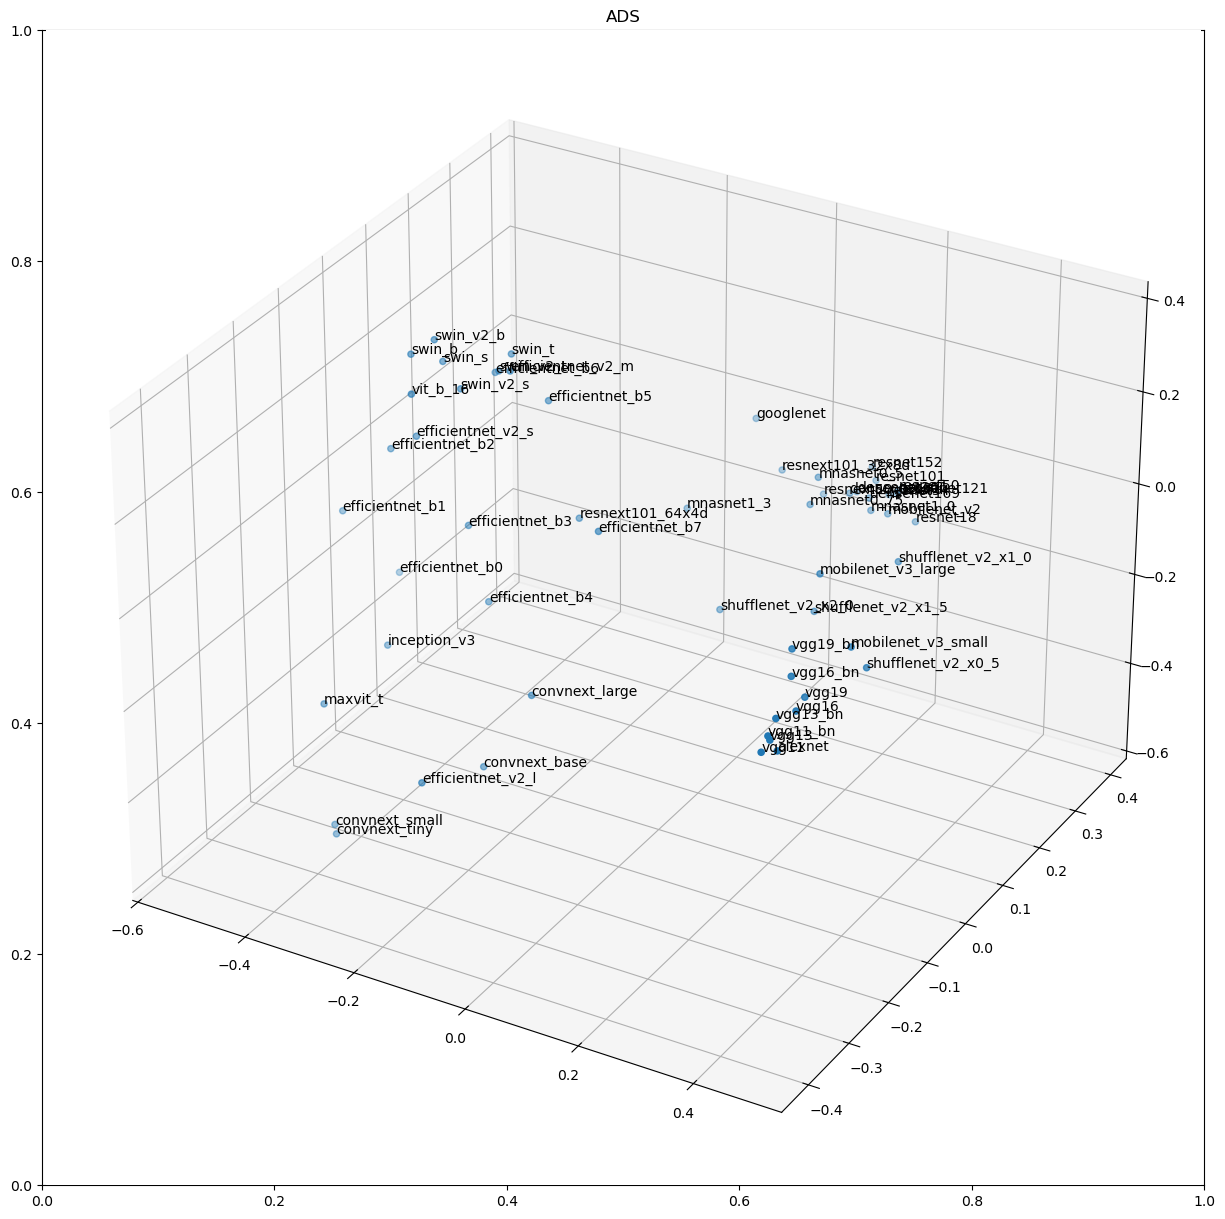

In [146]:
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(1,1,1)
ax = fig.add_subplot(projection='3d')

# ax.scatter(pcs1[:,0], pcs1[:,1])
ax.scatter(pcs1[:,0], pcs1[:,1], pcs1[:,2])

for i, txt in enumerate(model_names):
    # ax.text(pcs1[i,0], pcs1[i,1],txt)
    ax.text(pcs1[i,0], pcs1[i,1],pcs1[i,2],txt)


plt.title('ADS')

In [155]:
# CKA

embedding = MDS(n_components=60, metric= True, eps = 0.0001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(np.abs(np.real(dists_cka)))
embedding.stress_

np.float64(0.33284389731305786)

In [156]:
pca = PCA(n_components=3)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.35300925969141983)

Text(0.5, 0.92, 'CKA')

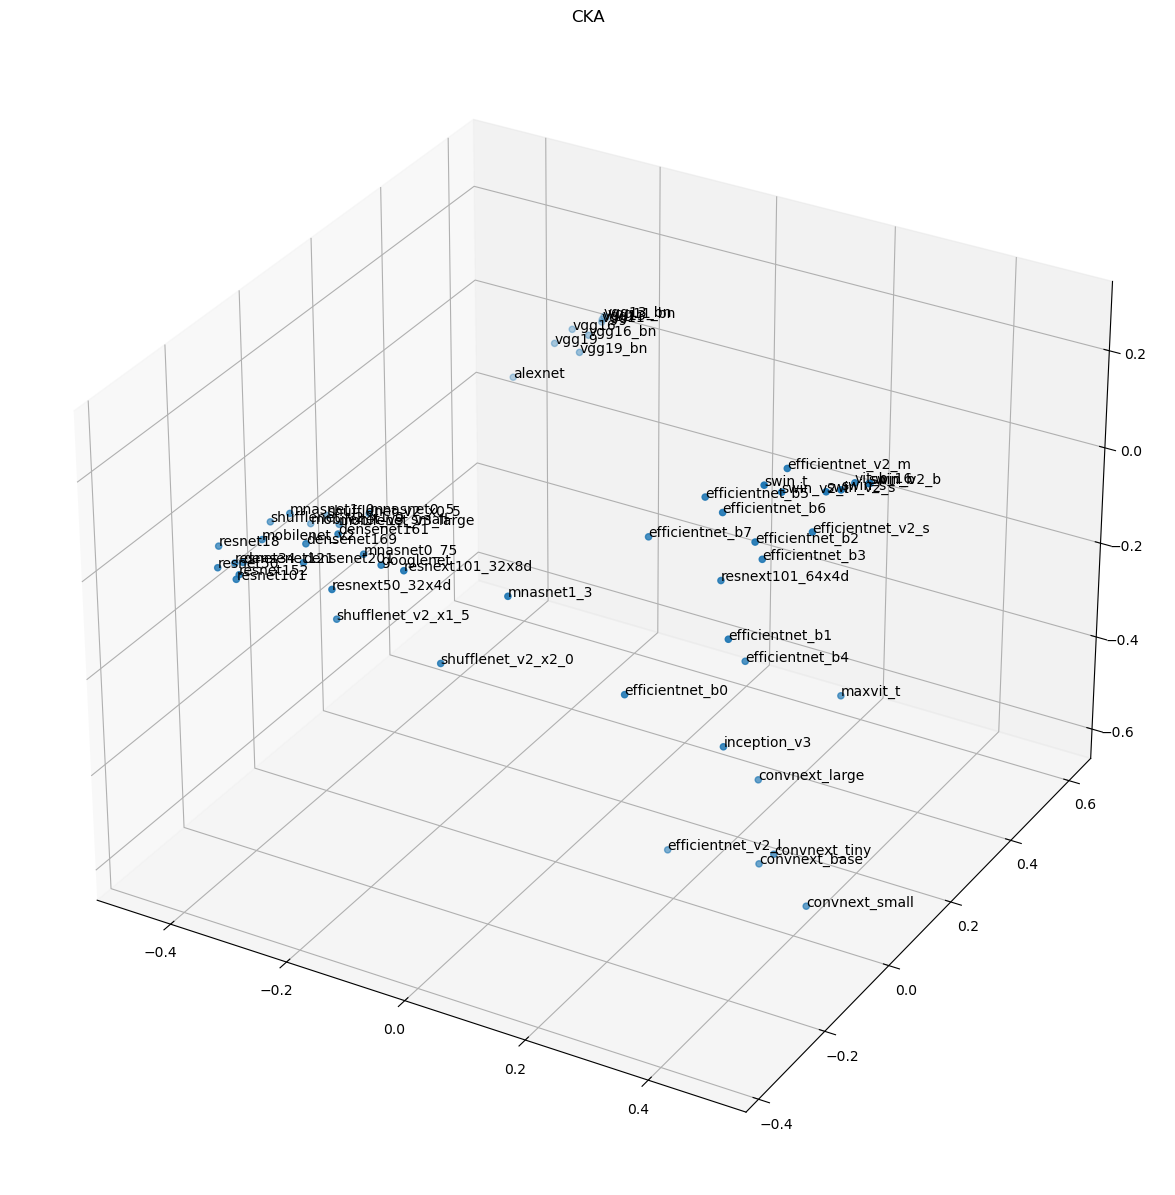

In [157]:
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(projection="3d")
# ax = fig.add_subplot()


# ax.scatter(pcs1[:,0], pcs1[:,1])
ax.scatter(pcs1[:,0], pcs1[:,1], pcs1[:,2])

for i, txt in enumerate(model_names):
    # ax.text(pcs1[i,0], pcs1[i,1],txt)
    ax.text(pcs1[i,0], pcs1[i,1],pcs1[i,2],txt)


plt.title('CKA')

# TO DO: make color related to number of neurons or accuracy

Text(0.5, 1.0, 'CKA')

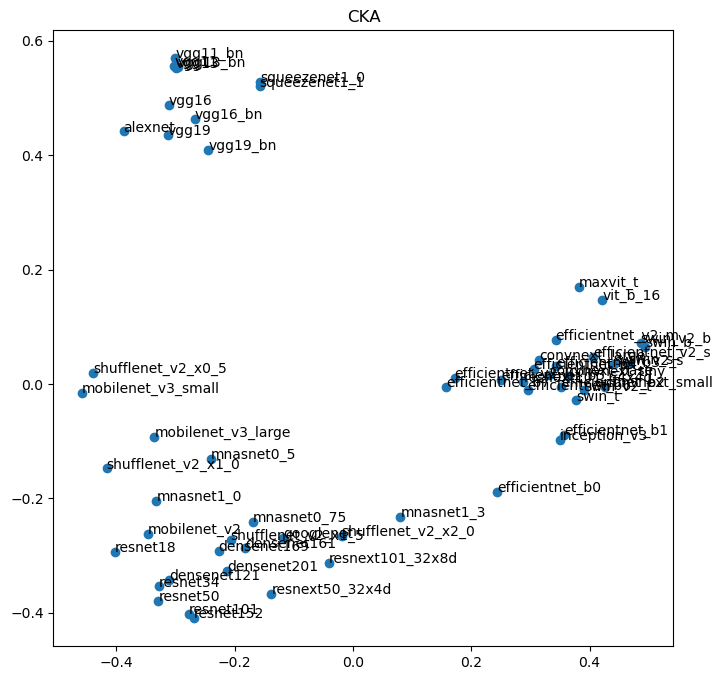

In [43]:
# 2D

fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(111)


ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)


plt.title('CKA')

# TO DO: make color related to number of neurons or accuracy

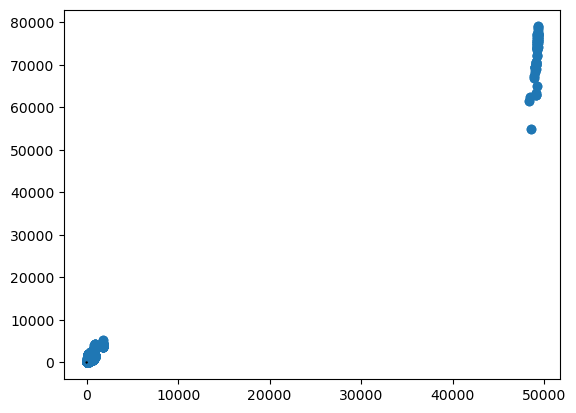

In [105]:
plt.scatter(np.reshape(euc_dist,-1),np.reshape(bures_dist,-1) )
plt.plot([0,1],[0,1],c='black')

In [ ]:
plt.scatter(np.reshape(dists_cka,-1),np.reshape(dists_ds,-1) )
plt.plot([0,1],[0,1],c='black')

In [107]:
# Euclidean distance  TO DO:  add option to normalize the kernel matrices to have trace or frobenius norm 1

embedding = MDS(n_components=40, metric= True, eps = 0.0001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(np.abs(np.real(euc_dist)))
embedding.stress_

np.float64(14791.587024380111)

In [108]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.9997210915841259)

Text(0.5, 1.0, 'Euclidean distance')

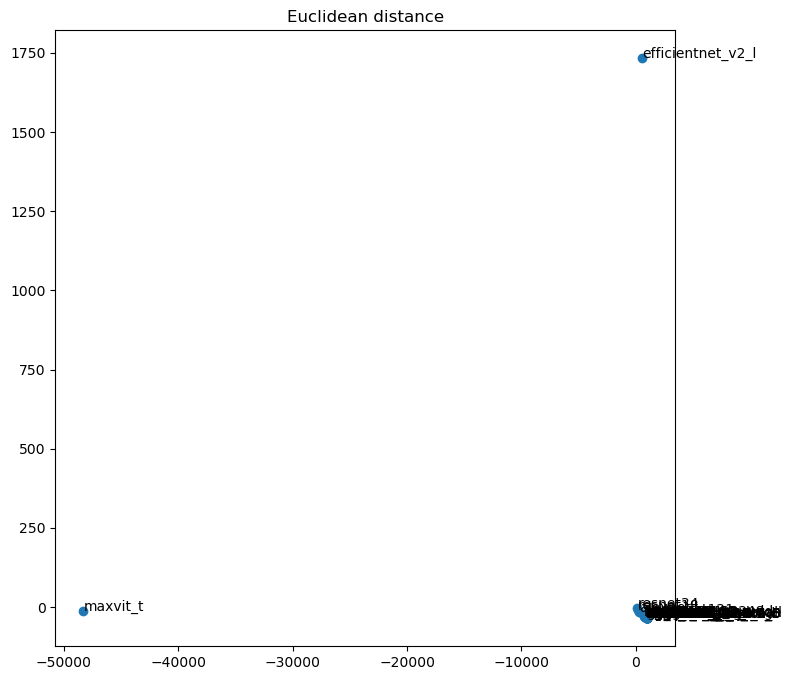

In [109]:
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

# for i, txt in enumerate(model_neurons):
#     ax.text(pcs1[i,0], pcs1[i,1]-20,txt)

plt.title('Euclidean distance')

# TO DO: make color related to number of neurons

Text(0.5, 1.0, 'Euclidean distance')

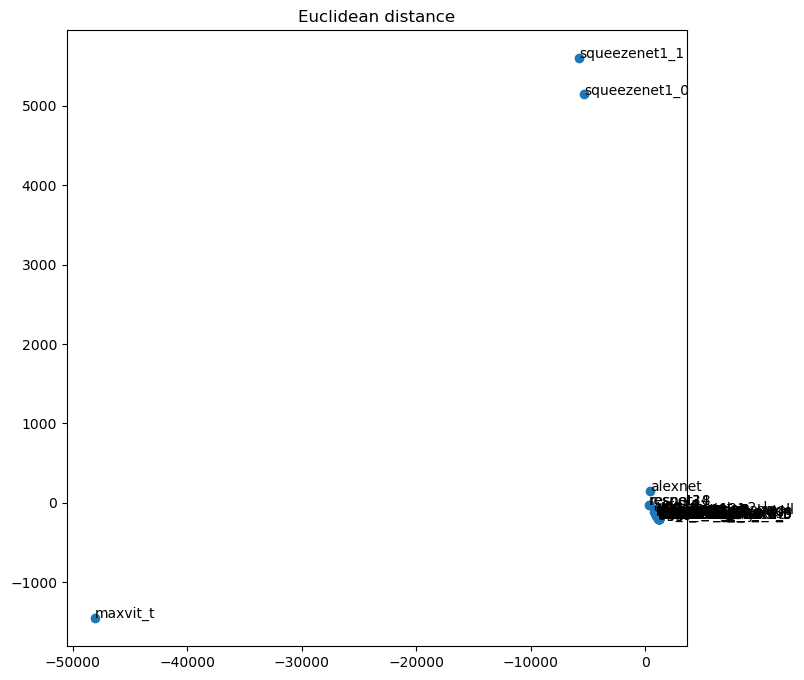

In [14]:
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

# for i, txt in enumerate(model_neurons):
#     ax.text(pcs1[i,0], pcs1[i,1]-20,txt)

plt.title('Euclidean distance')

# TO DO: make color related to number of neurons

In [110]:
# Bures/shape distance

embedding = MDS(n_components=40, metric= True, eps = 0.0001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(np.abs(np.real(bures_dist)))
embedding.stress_

np.float64(1175187169.760422)

In [111]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.9999563734662349)

Text(0.5, 1.0, 'Bures distance')

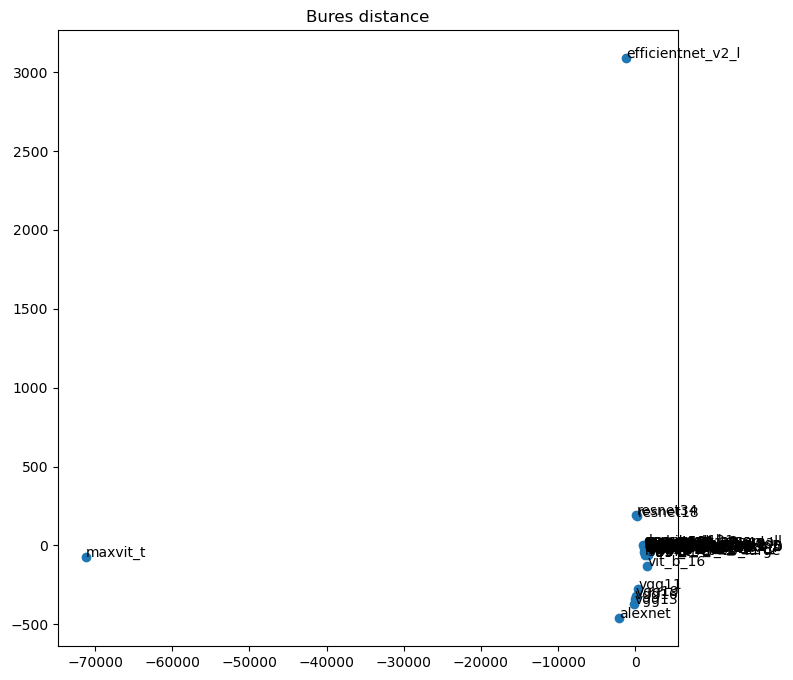

In [114]:
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

# for i, txt in enumerate(model_neurons):
#     ax.text(pcs1[i,0], pcs1[i,1]-20,txt)

plt.title('Bures distance')

# TO DO: make color related to number of neurons

Text(0.5, 1.0, 'Bures distance')

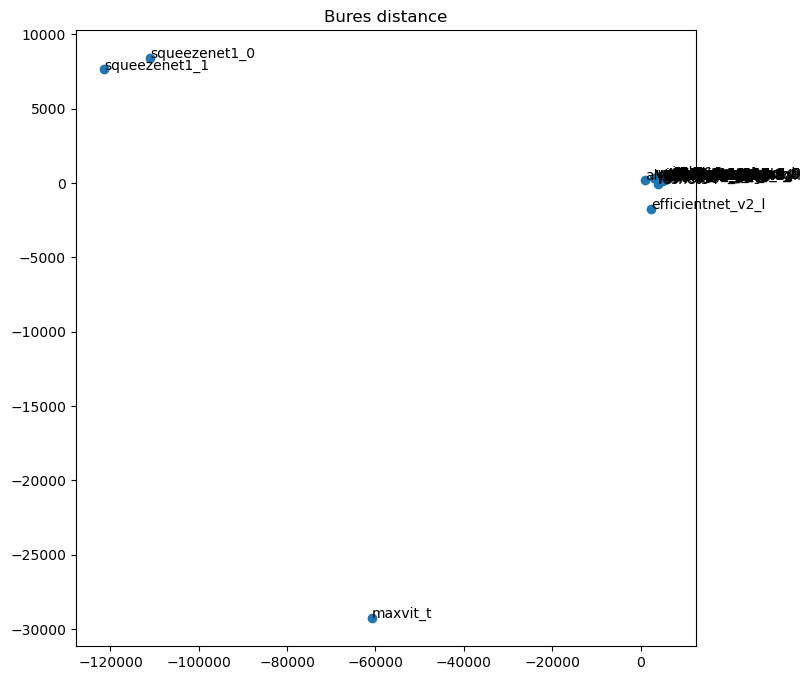

In [180]:
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

# for i, txt in enumerate(model_neurons):
#     ax.text(pcs1[i,0], pcs1[i,1]-20,txt)

plt.title('Bures distance')

# TO DO: make color related to number of neurons

### Many plots of ADS visualization while scanning over a parameter

In [ ]:
# OLD METHOD. TO DO: UPDATE

DSscores_scan = []

range_a = [0]

for a in range_a:

    ds = metrics.LinearDecodingSimilarity(center_columns=True, a = a, b = 1)

    Cz = dsutils.bespoke_cov_matrix(z)  # Coarse category decoding
    # Cz = dsutils.gaussian_partitions_cov_matrix(M,10)  # some random Gaussian tasks
    # Cz = np.identity(M)

    DSscores = np.zeros((len(internal_reps), len(internal_reps)))

    for i in range(len(internal_reps)):
        for j in range(len(internal_reps)):
            if j < i:
                DSscores[i,j] = ds.score(internal_reps[i].numpy(),internal_reps[j].numpy(),Cz)
        print(i)

    DSscores = DSscores + DSscores.T

    DSscores_scan.append(DSscores)

    print(a)

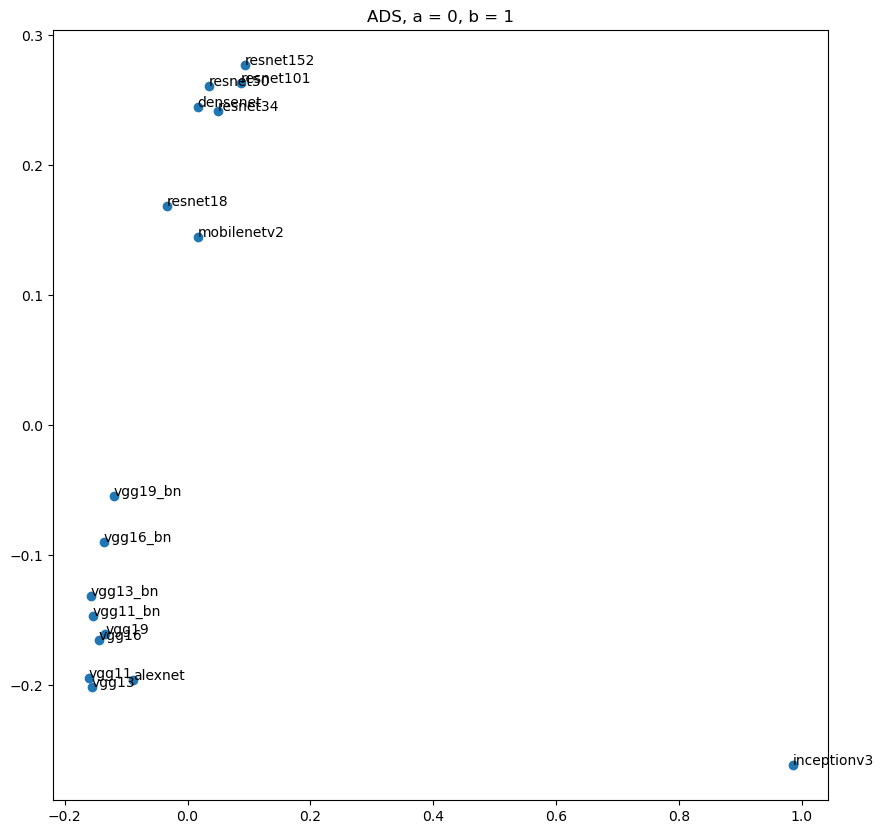

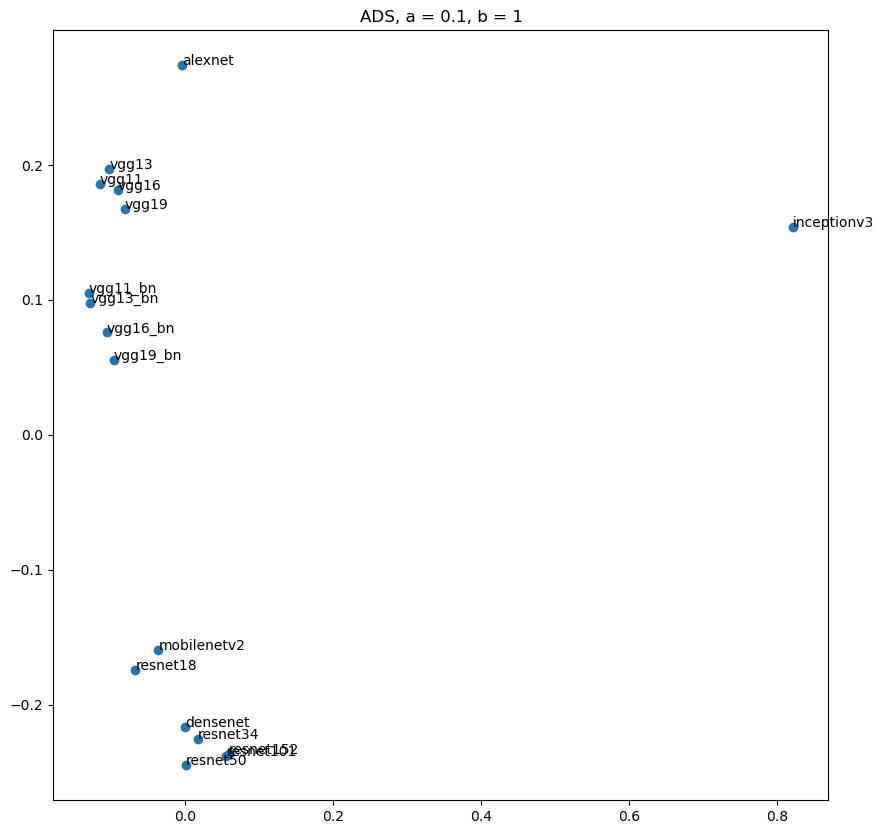

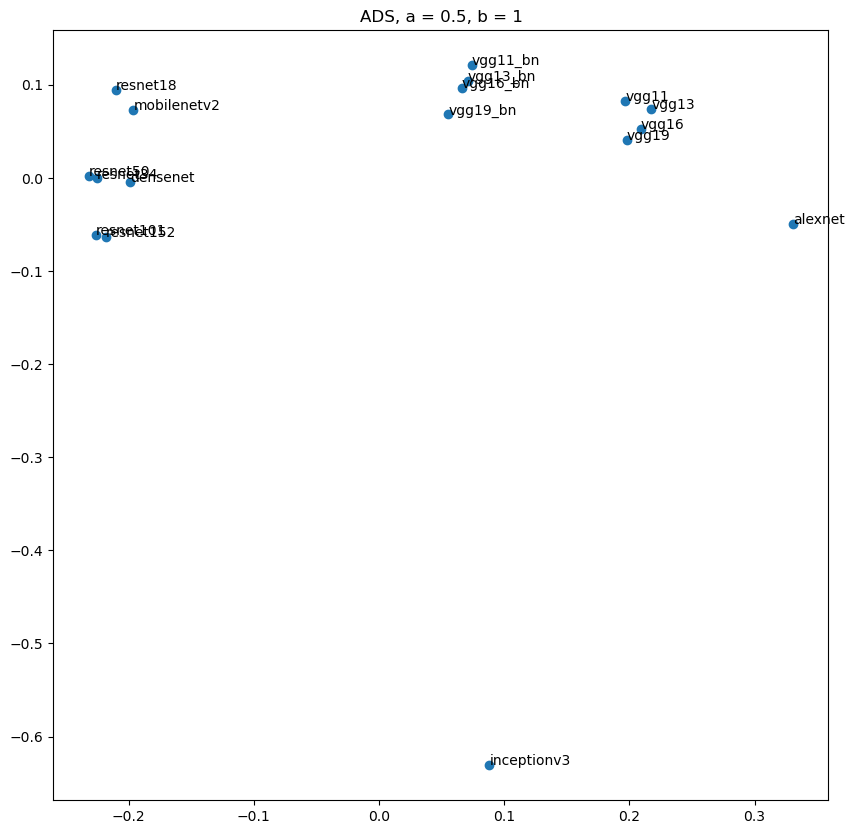

In [39]:
dists_ds_all = np.arccos(DSscores_scan)

for j in range(len(DSscores_scan)):

    dists_ds = dists_ds_all[j]

    embedding = MDS(n_components=15, metric= True, eps = 0.00001, normalized_stress='auto', dissimilarity='precomputed')
    Z = embedding.fit_transform(np.abs(np.real(dists_ds)))
    # embedding.stress_

    pca = PCA(n_components=2)
    pcs1 = pca.fit_transform(Z)
    # np.sum(pca.explained_variance_ratio_)

    fig = plt.figure(figsize= (10,10))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(pcs1[:,0], pcs1[:,1])

    for i, txt in enumerate(model_names):
        ax.text(pcs1[i,0], pcs1[i,1],txt)

    plt.title('ADS, a = ' + str(np.round(range_a[j],2)) +  ', b = 1')
    # plt.savefig('DSscores_scan_b_'+str(np.round(range_b[j],2))+'.pdf', transparent=None, dpi='figure', format=None,
    #     metadata=None, bbox_inches=None, pad_inches=0.1,
    #     facecolor='auto', edgecolor='auto')
    plt.show()